In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import sys; sys.path.append('./coco')
from pycocotools.coco import COCO
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time
from keras import Input, layers
from keras import optimizers
from tqdm import tqdm
import json
from pathlib import Path
import random
import pickle

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout, GRU
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


In [ ]:
img_path = '../data/Images/train2014/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = './drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sfl_train_smpl = pickle.load(open(drive_path+"/data/captions_3.pickle","rb"))
train_smpl = sfl_train_smpl[:int(len(sfl_train_smpl)*0.8)]
test_smpl = sfl_train_smpl[int(len(sfl_train_smpl)*0.8)+1:]

In [ ]:
s = ''
for i in sfl_train_smpl:
    id,d,l = i
    s+=str(l)+' '+str(id)+' '+d.replace('\n', ' ')+'\n'
doc = s

In [ ]:
disc = dict()
op = dict()
for line in doc.split('\n'):
    token = line.split()

    if len(line)>2:
        img = token[1].split('.')[0]
        dec = ' '.join(token[2:])
        if img not in disc:
            disc[img] = list()
            op[img] = list()
        op[img].append(int(token[0]))
        disc[img].append(dec)

In [ ]:
train_smpl[0]

('COCO_train2014_000000187844.jpg',
 'A plane on a snowy airstrip that is taking off.',
 1)

In [ ]:
table = str.maketrans('', '', string.punctuation)
for k,d in disc.items():
    for i in range(len(d)):
        x = d[i]
        x = x.split()
        x = [w.lower() for w in x]
        x = [w.translate(table) for w in x]
        d[i] = ' '.join(x)

In [ ]:
vocab = set()
for k in disc.keys():
    [vocab.update(d.split()) for d in disc[k]]
len(vocab)

13010

In [ ]:
l = list()
img_ids = list()
for k,d in disc.items():
    for i in range(len(d)):
        img_ids.append(k)
        l.append(k+' '+d[i])

data = l
img_ids = img_ids

print(l[:10])

['COCO_train2014_000000187844 a plane on a snowy airstrip that is taking off', 'COCO_train2014_000000187844 a small airplane on the runway getting ready to take off', 'COCO_train2014_000000187844 a large air plane on a run way', 'COCO_train2014_000000187844 a kitchen with a fruit pie being made probably apple', 'COCO_train2014_000000187844 a single doughnut on a plate next to a cup of coffee', 'COCO_train2014_000000187844 a young tball player begins to run towards first base with the ball midair in front of him', 'COCO_train2014_000000187844 a bird is sitting on the grass in a meadow next to a body of water', 'COCO_train2014_000000187844 a plane seems to have just landed from the sky', 'COCO_train2014_000000187844 there is an outdated mobile phone on a wooden table', 'COCO_train2014_000000187844 a plane is sitting on a landing strip']


In [ ]:
for i in range(len(img_ids)):
    img_ids[i]=img_path+img_ids[i]+'.jpg'

img_ids = set(img_ids)

In [ ]:
all_desc = dict()

for i in l:
    t = i.split()
    k,d = t[0],t[1:]
    if k not in all_desc:
        all_desc[k]=list()
    all_desc[k].append(' '.join(d))


In [ ]:
all_cap = list()
max_len = 0
for k,d in all_desc.items():
    for cap in d:
        if max_len<len(cap.split()):
            max_len=len(cap.split())
        all_cap.append(cap)
print(max_len)

49


In [ ]:
word = {}
sent = 0
word_count_th = 1

for s in all_cap:
    for w in s.split():
        word[w] = word.get(w,0)+1
vocab = [w for w in word if word[w]>=word_count_th]
vocab_size = len(vocab)
print(vocab_size)

13010


In [ ]:
def glove_process():
    _pad = "<pad>"
    _unk = "<unk>"
    _extra_vocab = [_pad, _unk]
    padid = 0
    unkid = 1

    word_mat = np.zeros((vocab_size+len(_extra_vocab),200))
    word2idx = {}
    idx2word = {}

    idx = 0

    for w in _extra_vocab:
        word2idx[w]=idx
        idx2word[idx]=w
        idx+=1

    for w in vocab:
        word2idx[w]=idx
        idx2word[idx]=w
        idx+=1

    f = open(drive_path+'/data/glove.6B.200d.txt','r')
    emb_mat = {}
    for line in tqdm(f, total=int(4e5)):
        line = line.lstrip().rstrip().split(" ")
        w = line[0]
        embedding = np.asarray(line[1:],dtype='float32')
        emb_mat[w]=embedding

    for k,v in word2idx.items():
        e = emb_mat.get(k)
        if e is not None:
           # print(v)
            word_mat[v]=e

    return word_mat, word2idx, idx2word

In [ ]:
em,word2idx,idx2word = glove_process()

100%|██████████| 400000/400000 [00:21<00:00, 18535.52it/s]


In [ ]:
vocab_size = len(vocab)+2

In [ ]:
enc_all = pickle.load(open(drive_path+'/data/enc_all.pickle','rb'))

In [ ]:
def pretrained_embedding_layer(voc_len,emb_mat):
    embedding_layer = Embedding(voc_len, 200,trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_mat])

    return embedding_layer

In [ ]:
def model_v1():
    input1 = Input(shape=(4096,),batch_size=10)
    f2 = Dense(1000,activation=None)(input1)

    input2 = Input(shape=(max_len,),batch_size=10)
    embedding_layer = pretrained_embedding_layer(vocab_size,em)
    #s1 = tf.keras.layers.Embedding(vocab_size, 200, input_length=max_len)(input2)
    s1 = embedding_layer(input2)
    s3 = LSTM(1000)(s1)

    concate = tf.concat(axis=1, values=[tf.nn.l2_normalize(f2, 1),
                                         tf.nn.l2_normalize(s3, 1),])

    dec = Dense(500, activation='relu',kernel_initializer='glorot_uniform')(concate)
    dec1 = Dense(1,activation=tf.nn.sigmoid,kernel_initializer='glorot_uniform')(dec)
    model = Model(inputs = [input1,input2],outputs=dec1)
    return model

In [ ]:
model1 = model_v1()

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(10, 49)]           0           []                               
                                                                                                  
 input_1 (InputLayer)           [(10, 4096)]         0           []                               
                                                                                                  
 embedding (Embedding)          (10, 49, 200)        2602400     ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (10, 1000)           4097000     ['input_1[0][0]']                
                                                                                              

In [ ]:
def weighed_logistic_loss(scores, labels, pos_loss_mult=1.0, neg_loss_mult=1.0):
    # Apply different weights to loss of positive samples and negative samples
    # positive samples have label 1 while negative samples have label 0
    loss_mult = tf.add(tf.multiply(labels, pos_loss_mult-neg_loss_mult), neg_loss_mult)
    # Classification loss as the average of weighed per-score loss
    cls_loss = tf.reduce_mean(tf.multiply(
       tf.nn.sigmoid_cross_entropy_with_logits(logits=scores, labels=labels),
       loss_mult))
    #p_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=scores, labels=labels)
    #n_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=scores, labels=loss_mult)
    #cls_loss = tf.reduce_mean(p_loss+n_loss)
    return cls_loss

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False, name="SGD",decay=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="auto",
    name="binary_crossentropy",
)
model1.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

In [ ]:
def batcher(desc,img_f,batch_size):
    x1,x2,y = list(),list(),list()
    n=0
    i = 0
    for i in range(len(desc)):
        id,d,l = desc[i]
        f1 = img_f[id]
        sq = [word2idx[w] for w in d.split() if w in word2idx]
        in_sq = pad_sequences([sq], maxlen=max_len)[0]
        out = float(l)
        x1.append(f1)
        x2.append(in_sq)
        y.append(out)
    return np.array(x1),np.array(x2),np.array(y)

In [ ]:
epoch = 10
batch_size = 1
steps = len(train_smpl[:80000])//10

x1,x2,y = batcher(train_smpl,enc_all,batch_size)
n = (len(x1)//10)*10
history = model1.fit([x1[:n],x2[:n]],y[:n] ,epochs=epoch, steps_per_epoch=steps, verbose=1, batch_size=10)

Epoch 1/10
8000/8000 [==============================] - 655s 81ms/step - loss: 0.5582 - accuracy: 0.6922
Epoch 2/10
8000/8000 [==============================] - 648s 81ms/step - loss: 0.3941 - accuracy: 0.8277
Epoch 3/10
8000/8000 [==============================] - 649s 81ms/step - loss: 0.3472 - accuracy: 0.8538
Epoch 4/10
8000/8000 [==============================] - 647s 81ms/step - loss: 0.3286 - accuracy: 0.8625
Epoch 5/10
8000/8000 [==============================] - 647s 81ms/step - loss: 0.3167 - accuracy: 0.8694
Epoch 6/10
6603/8000 [=======================>......] - ETA: 1:53 - loss: 0.3062 - accuracy: 0.8739

KeyboardInterrupt: ignored

In [ ]:
pickle.dump(history,open('./drive/MyDrive/data/h_e_10','wb'))

NameError: ignored

In [ ]:
pickle.dump(model1,open('./drive/MyDrive/data/m_e_10','wb'))

INFO:tensorflow:Assets written to: ram://f48bfa64-65c6-4bef-9beb-5d21508f92f7/assets


INFO:tensorflow:Assets written to: ram://f48bfa64-65c6-4bef-9beb-5d21508f92f7/assets


In [ ]:
test_x1,test_x2,y = list(),list(),list()
n=0
res = []
for k in tqdm(range(len(test_smpl))):
      test_x1,test_x2,y = list(),list(),list()
      id,d,l = test_smpl[k]
      f1 = enc_all[id]
      sq = [word2idx[w] for w in d.split() if w in word2idx]
      in_sq = pad_sequences([sq], maxlen=max_len)[0]
      out = float(l)
      test_x1.append(f1)
      test_x2.append(in_sq)
      p = model1.predict([array(test_x1),array(test_x2)],batch_size=1)
      res.append((id,d,p[0][0],out))
print(res)

  0%|          | 0/20011 [00:00<?, ?it/s]

 26%|██▋       | 5294/20011 [06:06<16:57, 14.46it/s]


KeyboardInterrupt: ignored

In [ ]:
pickle.dump(res,open("result.pickle",'wb'))

## Demo

In [ ]:
model = VGG16(weights='imagenet')
model_new = Model(model.input,model.layers[-2].output)

553476096/553467096 [==============================] - 9s 0us/step


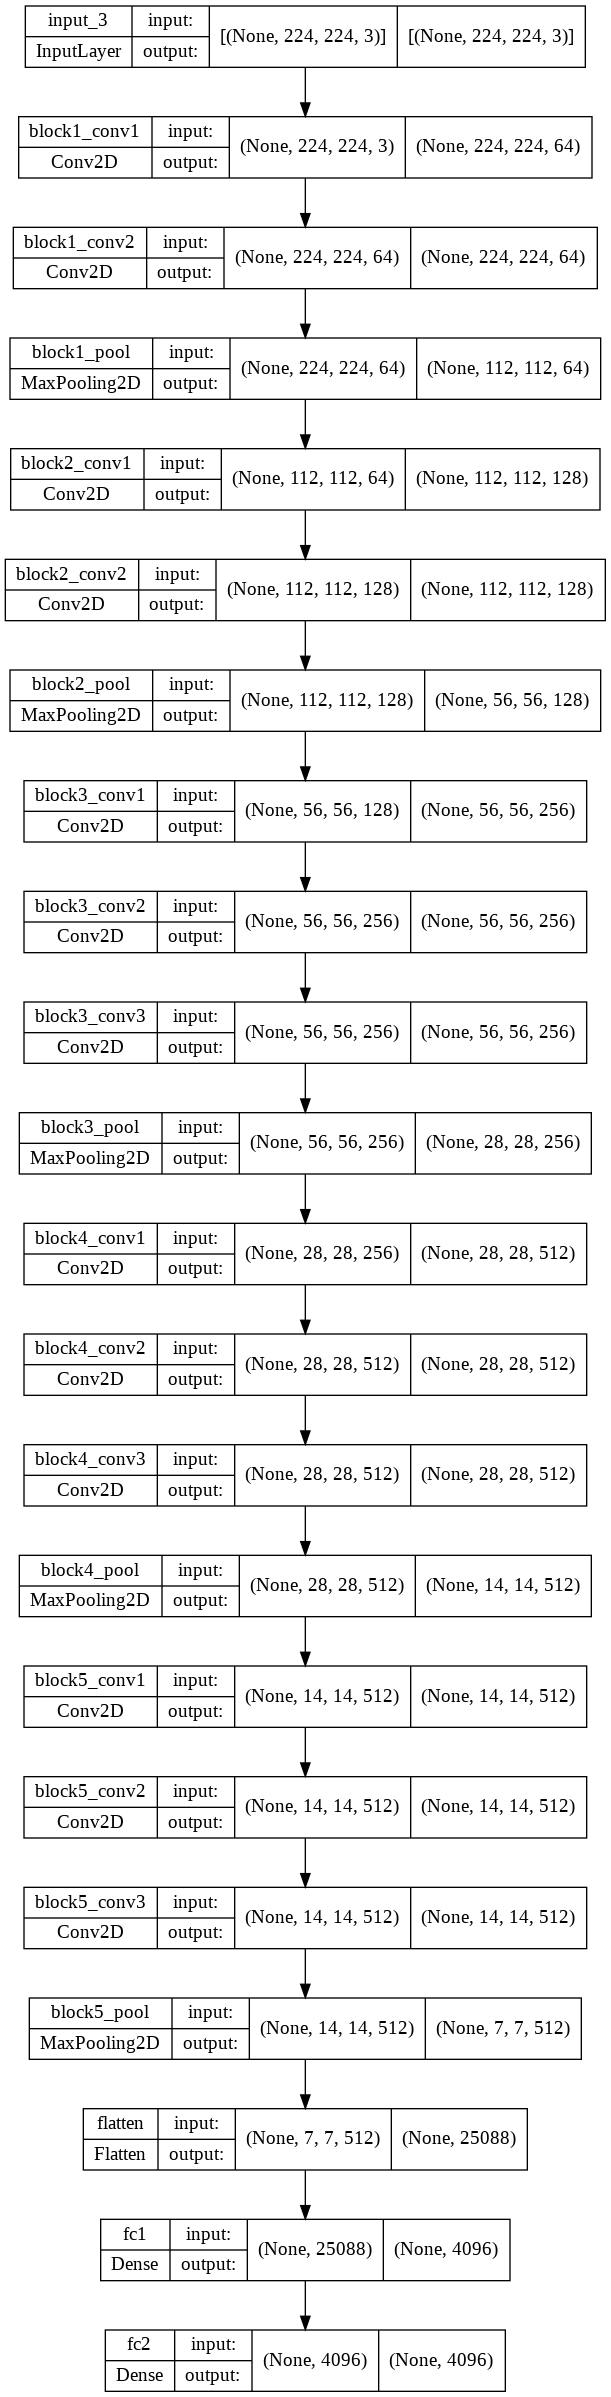

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_new, show_shapes=True)

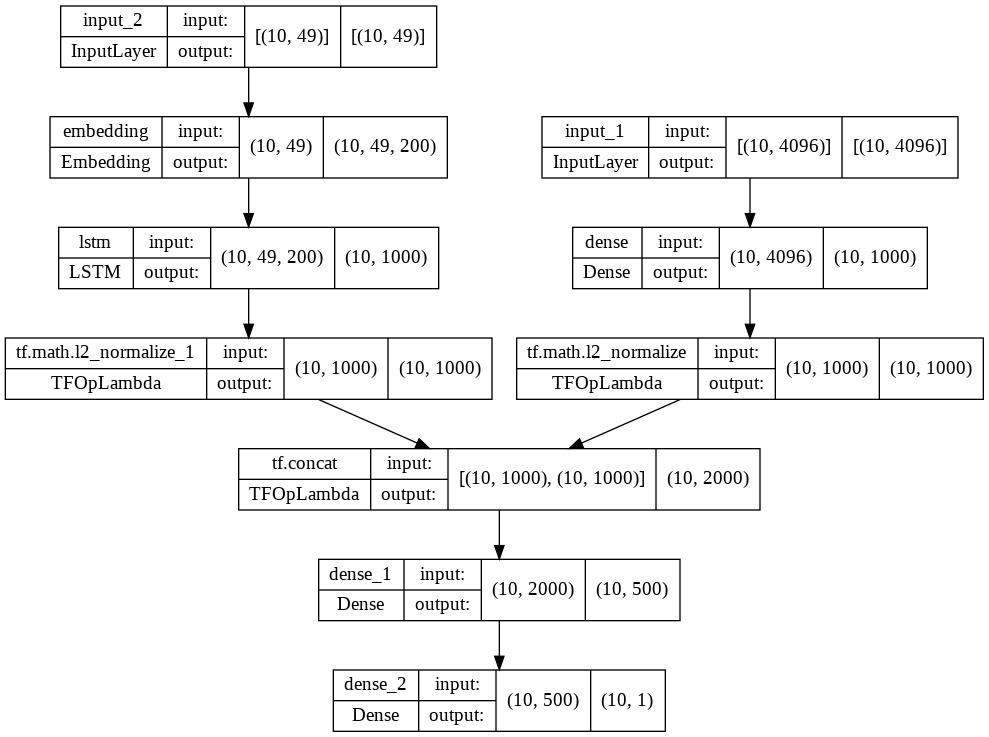

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model1, show_shapes=True)

In [ ]:
def process(img_path):
    i = tf.keras.utils.load_img(img_path,target_size=(224,224))
    x = image.img_to_array(i)
    x = np.expand_dims(x,axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
def encode_img(img):
    i = process(img)
    fec = np.array(model_new.predict(i))
    fec = np.reshape(fec,fec.shape[1])
    return fec

In [ ]:
def test(img,cap):
  x1 = list()
  x2 = list()
  sq = [word2idx[w] for w in cap.split() if w in word2idx]
  in_sq = pad_sequences([sq], maxlen=49)[0]
  model5 = pickle.load(open('./drive/MyDrive/data/m_e_10','rb'))
  x1.append(img)
  x2.append(in_sq)
  p = model5.predict([np.array(x1),np.array(x2)],batch_size=1)
  return p

In [ ]:
img = encode_img("./drive/MyDrive/test_data/test.jpg")
cap_pos = "Heavy rain"
cap_neg = "Red Car with 4 persons."

r = test(img,cap_pos)
print("prediction: "+str(r))

#r2 = test(img,cap_neg)
#print("prediction: "+str(r2))



prediction: [[0.519299]]
